## INF2209 Final Submission

#### Hong Shi         1002685070

The raw data is about The International 10 (abbreviated as TI10). It was collceted through Twitter's open application programming interface (API) using the rtweet package in R. The data is collected based on Twitter hashtag #TI10 and only original posts are collected (excluding retweets), and it was started to be collected around Oct 18 9:00 PM EST, approximately 30 hours after the end of Ti10 tournament. The data contains all original tweets with hashtag #Ti10 between Oct 10th and Oct 18th (relative to EST timezone).

About Ti10:
The International 10 is the tenth iteration of The International, an annual Dota 2 world championship esports tournament. It is hosted by the game developer Valve. 

### Setup

In [1]:
# SETUP
import numpy as np
import pandas as pd
import os
import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from pandas.api.types import CategoricalDtype

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
# eda setup
from plotnine import *
from plotnine.data import *
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
!pip install bitermplus

     |████████████████████████████████| 614 kB 5.1 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for bitermplus: filename=bitermplus-0.6.10-cp37-cp37m-linux_x86_64.whl size=931273 sha256=e60b399b37675733d5038f6ece1042732ada46ca12c25ce1646de3f6cc355163
  Stored in directory: /root/.cache/pip/wheels/2b/1a/8d/58328971ebe27f346b2e0c05ea9fe45bc67986310557074141
Successfully built bitermplus


In [7]:
# Need to upgrade to lastest gensim to get gensim nmf model running
!pip install --upgrade gensim

     |████████████████████████████████| 24.1 MB 25.2 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [4]:
import gensim
import gensim.corpora as corpora
from pprint import pprint
import bitermplus as btm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
#from sklearn.feature_extraction import text
import spacy
import datetime
import itertools
from collections import Counter
from gensim.utils import simple_preprocess
from gensim.models import Nmf

In [5]:
from datetime import timedelta

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
# Read in the raw data
raw_ti10 = pd.read_csv('new_ti10_tweets.csv', encoding = 'utf-8')

#### Breifly examine the data

In [8]:
pd.set_option("display.max_columns", None)
raw_ti10.head()

user_id             status_id           created_at  \
0  x1290210901543596035  x1450265609837625353  2021-10-19 01:00:40   
1           x1227015854  x1450265585749741569  2021-10-19 01:00:34   
2           x1227015854  x1449897704268697604  2021-10-18 00:38:45   
3           x1227015854  x1449756111268163591  2021-10-17 15:16:06   
4           x1227015854  x1449871356200464394  2021-10-17 22:54:03   

     screen_name                                               text  \
0  ANIMATIONWEB5  #alterpinay #LISA #Attacca #TI10 #honktwtselfi...   
1    Dota2Lounge  Miposhka shared in the team's vlog what really...   
2    Dota2Lounge  Crazy to think that #TI10 is over. These were ...   
3    Dota2Lounge  The level of performance by both teams is amaz...   
4    Dota2Lounge  This meta <U+0001F923> \r\n\r\n#dota2 #ti10 ht...   

                source  display_text_width reply_to_status_id  \
0  Twitter for Android                 279                NaN   
1               Buffer                 118                NaN   
2      Twitter Web App                 107                NaN   
3               Buffer                  64                NaN   
4               Buffer                  26                NaN   

  reply_to_user_id reply_to_screen_name  is_quote  is_retweet  favorite_count  \
0              NaN                  NaN     False       False               1   
1              NaN                  NaN     False       False               2   
2              NaN                  NaN     False       False               5   
3              NaN                  NaN     False       False               0   
4              NaN                  NaN     False       False               8   

   retweet_count  quote_count  reply_count  \
0              1          NaN          NaN   
1              0          NaN          NaN   
2              2          NaN          NaN   
3              1          NaN          NaN   
4              1          NaN          NaN   

                                            hashtags symbols urls_url  \
0  alterpinay LISA Attacca TI10 honktwtselfieday ...     NaN      NaN   
1                                         TI10 dota2     NaN      NaN   
2                                               TI10     NaN      NaN   
3                                         dota2 ti10     NaN      NaN   
4                                         dota2 ti10     NaN      NaN   

  urls_t.co urls_expanded_url  \
0       NaN               NaN   
1       NaN               NaN   
2       NaN               NaN   
3       NaN               NaN   
4       NaN               NaN   

                                           media_url               media_t.co  \
0     http://pbs.twimg.com/media/FCBg4sLXsAgUmQi.jpg  https://t.co/MS6GpBxMD6   
1  http://pbs.twimg.com/ext_tw_video_thumb/145026...  https://t.co/oIzjjGuNDW   
2     http://pbs.twimg.com/media/FB8Rd2CX0AELMGp.jpg  https://t.co/e9gQ15Qgo6   
3  http://pbs.twimg.com/ext_tw_video_thumb/144975...  https://t.co/TUOjs0xXe9   
4     http://pbs.twimg.com/media/FB76UIUXEAEqOqn.jpg  https://t.co/d0GEdB9wI1   

                                  media_expanded_url media_type  \
0  https://twitter.com/ANIMATIONWEB5/status/14502...      photo   
1  https://twitter.com/Dota2Lounge/status/1450265...      photo   
2  https://twitter.com/Dota2Lounge/status/1449897...      photo   
3  https://twitter.com/Dota2Lounge/status/1449756...      photo   
4  https://twitter.com/Dota2Lounge/status/1449871...      photo   

                                       ext_media_url           ext_media_t.co  \
0     http://pbs.twimg.com/media/FCBg4sLXsAgUmQi.jpg  https://t.co/MS6GpBxMD6   
1  http://pbs.twimg.com/ext_tw_video_thumb/145026...  https://t.co/oIzjjGuNDW   
2     http://pbs.twimg.com/media/FB8Rd2CX0AELMGp.jpg  https://t.co/e9gQ15Qgo6   
3  http://pbs.twimg.com/ext_tw_video_thumb/144975...  https://t.co/TUOjs0xXe9   
4     http://pbs.twimg.com/media/FB76UIUXEAEqOqn.jpg  https://t.co/d0GEdB9wI1   

In [9]:
# Size of the raw dataset
raw_ti10.shape

(41839, 90)

## **Preprocessing**

##### 1. Keep only English tweets

In [10]:
raw_ti10.lang.unique()

array(['und', 'en', 'es', 'pt', 'in', 'ru', 'zh', 'tl', 'sl', 'th', 'ro',
       'ar', 'nl', 'fa', 'de', 'fr', 'cs', 'ja', 'lv', 'sv', 'et', 'da',
       'fi', 'eu', 'bg', 'it', 'no', 'hi', 'is', 'uk', 'vi', 'ca', 'ht',
       'pl', 'cy', 'hu', 'lt', 'ko', 'sr', 'tr', 'si'], dtype=object)

In [11]:
en_ti10 = raw_ti10[raw_ti10["lang"] == 'en']
# There are 26839 English tweets defined by Twitter API
en_ti10.shape[0]

26839

##### 2. Remove URLs

In [12]:
#sample tweet raw text in text column of the data
test_text = "@Team__Spirit Miposhka shared in the team's vlog what really helped the team to achieve their well-deserved victory at #TI10\r\n\r\n#dota2 https://t.co/oIzjjGuNDW"

In [13]:
def remove_URL(text):
    """Remove URLs from tweet text"""
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    return text

In [14]:
# function test
test_text = remove_URL(test_text)
test_text

"@Team__Spirit Miposhka shared in the team's vlog what really helped the team to achieve their well-deserved victory at #TI10\r\n\r\n#dota2 "

##### 3. Remove Hashtags

In [15]:
# Example of tweets with hashtags (add a "#" symbol before a phrase, e.g. #Ti10)
en_ti10[en_ti10.text.str.contains('#')].text.iloc[0]

"Miposhka shared in the team's vlog what really helped the team to achieve their well-deserved victory at #TI10\r\n\r\n#dota2 https://t.co/oIzjjGuNDW"

In [16]:
# Example of tweets with mentions (add a "@" symbol before a tweet user, e.g. @EvilGeniuses)
en_ti10[en_ti10.text.str.contains('@')].text.iloc[1]

"The only one I managed to win, thanks to bulba's drafts.\r\n@EvilGeniuses #Dota2 #TI10 https://t.co/W4qlXkKzBE"

In [17]:
# hashtags always contain the search term #ti10, and the top frequenct hashtags contain DOTA2 game name, which is already within the data collection context
en_ti10.hashtags.value_counts()

TI10                                                       17356
TI10 Dota2                                                  1341
ti10                                                         965
Dota2 TI10                                                   482
DreamOG TI10                                                 300
                                                           ...  
LateGame TI10                                                  1
VALORANTLCQ TI10                                               1
Dota2 TI10 Team                                                1
Ti10 TI10GrandFinals TheInternational PSGLGD TeamSpirit        1
esports TI10 dota2 dota2TI LeagueOfLegends gaming              1
Name: hashtags, Length: 2510, dtype: int64

In [18]:
# mentions mostly contatins different teams participating TI10, e.g.Team_Spirit
en_ti10.mentions_screen_name.value_counts()

Team__Spirit                 1598
OGesports                     431
teamsecret                    374
T1                            323
EvilGeniuses                  126
                             ... 
hexaSSC dota2ti                 1
OG_BDN0tail Ceb OGesports       1
SirActionSlacks QOdota          1
EthanKairos_                    1
VICI invgaming T1               1
Name: mentions_screen_name, Length: 1459, dtype: int64

Would like to remove only hashtags but not the mentions

In [19]:
def remove_hashtag(text):
    """Remove hashtags from tweet text"""
    return re.sub(r"#\S+", "", text)

In [20]:
# function test
test_text = remove_hashtag(test_text)
test_text

"@Team__Spirit Miposhka shared in the team's vlog what really helped the team to achieve their well-deserved victory at \r\n\r\n "

##### 4. Remove Emojis (Unicode characters)

In [21]:
# example of tweets with unicode characters
# <U+0001F923> belongs to an emoji symbol
en_ti10.text.iloc[3]

'This meta <U+0001F923> \r\n\r\n#dota2 #ti10 https://t.co/d0GEdB9wI1'

In [22]:
def remove_unicode_char(text):
    """Remove unicode character from tweet text"""
    return re.sub(r"<U\+\S+", "", text)

In [23]:
# function test
remove_unicode_char(en_ti10.text.iloc[3])

'This meta  \r\n\r\n#dota2 #ti10 https://t.co/d0GEdB9wI1'

##### 5. Remove newlines

In [24]:
def remove_newline_char(text):
    """Remove newline character from tweet text"""
    text = re.sub(r"\r", "", text)
    text = re.sub(r"\n", "", text)
    return text

In [25]:
# function test
test_text = remove_newline_char(test_text)
test_text

"@Team__Spirit Miposhka shared in the team's vlog what really helped the team to achieve their well-deserved victory at  "

##### 6. Remove punctuations and lowercase characters

In [26]:
def no_punc_lower(text):
    """Remove punctuations and lowercase characters from tweet text"""
    text = re.sub("'","", text) # to avoid removing contraction
    text = re.sub("\W", " ", text).lower()
    # optional to remove Twitter account name Team__Spirit
    text = re.sub("__"," ", text)
    text = re.sub("_"," ", text)
    return text

In [27]:
# function test
test_text = no_punc_lower(test_text)
test_text

' team spirit miposhka shared in the teams vlog what really helped the team to achieve their well deserved victory at  '

##### 7. Remove Stopwords

In [28]:
stop_words = set(stopwords.words('english'))

In [29]:
def remove_stopwords(text):
  #Remove NLTK stopwords from tweet text
  return ' '.join([word for word in text.split() if word not in (stop_words)])

In [30]:
# function test
test_text = remove_stopwords(test_text)
test_text

'team spirit miposhka shared teams vlog really helped team achieve well deserved victory'

##### 8. Tokenize the sentence and get the lemma of tokens

Tokenization could be achieved through word_tokenize function in nltk

In [31]:
def get_pos_tags(words):
    '''Get the part of speech for lemmatization''' 
    tags=[]
    for word in words:
        tags.append(nltk.pos_tag([word]))
    return tags

In [32]:
def get_lemma(word_tags):
    '''Lemmatize the word'''
    wordnet_lemmatizer = WordNetLemmatizer()
    lemma = []
    for element in word_tags:
        word = element[0][0]
        pos = element[0][1]
        tag = nltk.pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                   "N": wordnet.NOUN,
                   "V": wordnet.VERB,
                   "R": wordnet.ADV}
        wordnet_pos = tag_dict.get(tag, wordnet.NOUN)
        lemma.append(wordnet_lemmatizer.lemmatize(word, wordnet_pos))
    return(lemma)

In [33]:
# function_test
get_lemma(get_pos_tags(word_tokenize(test_text)))

['team',
 'spirit',
 'miposhka',
 'share',
 'team',
 'vlog',
 'really',
 'help',
 'team',
 'achieve',
 'well',
 'deserve',
 'victory']

##### Apply all of the above functions on the raw tweet text in sequence to clean data

In [34]:
en_ti10["clean_text"] = \
en_ti10["text"].apply(remove_URL).apply(remove_hashtag).apply(remove_unicode_char).apply(remove_newline_char).apply(no_punc_lower).apply(remove_stopwords)

In [35]:
# sample output
en_ti10.clean_text.iloc[0:4]

1    miposhka shared teams vlog really helped team ...
2         crazy think picked heroes think needs tuning
3                      level performance teams amazing
4                                                 meta
Name: clean_text, dtype: object

In [36]:
en_ti10["clean_text_token"] = \
en_ti10["clean_text"].apply(word_tokenize).apply(get_pos_tags).apply(get_lemma)

In [37]:
# sample output
en_ti10.clean_text_token.iloc[0:4]

1    [miposhka, share, team, vlog, really, help, te...
2      [crazy, think, picked, hero, think, need, tune]
3                    [level, performance, team, amaze]
4                                               [meta]
Name: clean_text_token, dtype: object

In [38]:
# use lemmatized text for analysis
en_ti10["lemmatized_text"] = en_ti10["clean_text_token"].apply(" ".join)
en_ti10.head()

user_id             status_id           created_at  screen_name  \
1  x1227015854  x1450265585749741569  2021-10-19 01:00:34  Dota2Lounge   
2  x1227015854  x1449897704268697604  2021-10-18 00:38:45  Dota2Lounge   
3  x1227015854  x1449756111268163591  2021-10-17 15:16:06  Dota2Lounge   
4  x1227015854  x1449871356200464394  2021-10-17 22:54:03  Dota2Lounge   
5  x1227015854  x1449720425609633793  2021-10-17 12:54:18  Dota2Lounge   

                                                text           source  \
1  Miposhka shared in the team's vlog what really...           Buffer   
2  Crazy to think that #TI10 is over. These were ...  Twitter Web App   
3  The level of performance by both teams is amaz...           Buffer   
4  This meta <U+0001F923> \r\n\r\n#dota2 #ti10 ht...           Buffer   
5  Team Spirit dominating game 1\r\n\r\n#dota2 #t...           Buffer   

   display_text_width reply_to_status_id reply_to_user_id  \
1                 118                NaN              NaN   
2                 107                NaN              NaN   
3                  64                NaN              NaN   
4                  26                NaN              NaN   
5                  43                NaN              NaN   

  reply_to_screen_name  is_quote  is_retweet  favorite_count  retweet_count  \
1                  NaN     False       False               2              0   
2                  NaN     False       False               5              2   
3                  NaN     False       False               0              1   
4                  NaN     False       False               8              1   
5                  NaN     False       False               0              0   

   quote_count  reply_count    hashtags symbols urls_url urls_t.co  \
1          NaN          NaN  TI10 dota2     NaN      NaN       NaN   
2          NaN          NaN        TI10     NaN      NaN       NaN   
3          NaN          NaN  dota2 ti10     NaN      NaN       NaN   
4          NaN          NaN  dota2 ti10     NaN      NaN       NaN   
5          NaN          NaN  dota2 ti10     NaN      NaN       NaN   

  urls_expanded_url                                          media_url  \
1               NaN  http://pbs.twimg.com/ext_tw_video_thumb/145026...   
2               NaN     http://pbs.twimg.com/media/FB8Rd2CX0AELMGp.jpg   
3               NaN  http://pbs.twimg.com/ext_tw_video_thumb/144975...   
4               NaN     http://pbs.twimg.com/media/FB76UIUXEAEqOqn.jpg   
5               NaN  http://pbs.twimg.com/ext_tw_video_thumb/144972...   

                media_t.co                                 media_expanded_url  \
1  https://t.co/oIzjjGuNDW  https://twitter.com/Dota2Lounge/status/1450265...   
2  https://t.co/e9gQ15Qgo6  https://twitter.com/Dota2Lounge/status/1449897...   
3  https://t.co/TUOjs0xXe9  https://twitter.com/Dota2Lounge/status/1449756...   
4  https://t.co/d0GEdB9wI1  https://twitter.com/Dota2Lounge/status/1449871...   
5  https://t.co/C3YUzzFAA7  https://twitter.com/Dota2Lounge/status/1449720...   

  media_type                                      ext_media_url  \
1      photo  http://pbs.twimg.com/ext_tw_video_thumb/145026...   
2      photo     http://pbs.twimg.com/media/FB8Rd2CX0AELMGp.jpg   
3      photo  http://pbs.twimg.com/ext_tw_video_thumb/144975...   
4      photo     http://pbs.twimg.com/media/FB76UIUXEAEqOqn.jpg   
5      photo  http://pbs.twimg.com/ext_tw_video_thumb/144972...   

            ext_media_t.co                             ext_media_expanded_url  \
1  https://t.co/oIzjjGuNDW  https://twitter.com/Dota2Lounge/status/1450265...   
2  https://t.co/e9gQ15Qgo6  https://twitter.com/Dota2Lounge/status/1449897...   
3  https://t.co/TUOjs0xXe9  https://twitter.com/Dota2Lounge/status/1449756...   
4  https://t.co/d0GEdB9wI1  https://twitter.com/Dota2Lounge/status/1449871...   
5  https://t.co/C3YUzzFAA7  https://twitter.com/Dota2Lounge/status/1449720...   

   ext_media_type mentions_user_id men

In [ ]:
en_ti10.info()

## **EDA**

In [125]:
test_df = en_ti10.copy()

In [126]:
test_df['created_at'] = pd.to_datetime(test_df["created_at"])

In [127]:
test_df['created_at'].head()

1   2021-10-19 01:00:34
2   2021-10-18 00:38:45
3   2021-10-17 15:16:06
4   2021-10-17 22:54:03
5   2021-10-17 12:54:18
Name: created_at, dtype: datetime64[ns]

Notice that the created time of tweets may be too precise to generate a proper visualization, so decide to round the time into nearest half hour/ hour

In [128]:
test_df = test_df.sort_values(by = "created_at")

In [44]:
def half_rounder(t):
    if t.minute >= 45:
        return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour) + timedelta(hours=t.minute//30))
    elif t.minute <15:
        return t.replace(second=0, microsecond=0, minute=0)     
    else:
        return t.replace(second=0, microsecond=0, minute=30)

In [45]:
def hour_rounder(t):
    # Rounds to nearest hour by adding a timedelta hour if minute >= 30
    return (t.replace(second=0, microsecond=0, minute=0, hour=t.hour)
               +timedelta(hours=t.minute//30))

In [130]:
test_df['created_at'] = test_df['created_at'].apply(half_rounder)

In [131]:
test_df.head()

user_id             status_id          created_at  \
41838            x529762523  x1447061771643076610 2021-10-10 05:00:00   
41837            x529762523  x1447061771643076610 2021-10-10 05:00:00   
37662           x3814210037  x1447064350683025408 2021-10-10 05:00:00   
41836   x928966458628915200  x1447066196403122178 2021-10-10 05:00:00   
34689  x1352227175257284624  x1447067991330340865 2021-10-10 05:00:00   

          screen_name                                               text  \
41838  VortexContinum  @BladeRnnrQuote @copperbottomus We agree. Huma...   
41837  VortexContinum  @BladeRnnrQuote @copperbottomus We agree. Huma...   
37662    Team__Spirit  Schedule for the last day of #TI10 Group Stage...   
41836   stickman_o_o_  How are they gonna put crowd scenes in true si...   
34689       SuperPOG_  Picks for #TI10's last day of the group stage ...   

                    source  display_text_width    reply_to_status_id  \
41838  Twitter for Android                 206  x1446973762197393408   
41837  Twitter for Android                 206  x1446973762197393408   
37662      Twitter Web App                  72                   NaN   
41836  Twitter for Android                  98                   NaN   
34689  Twitter for Android                  82                   NaN   

           reply_to_user_id reply_to_screen_name  is_quote  is_retweet  \
41838  x1279004605289037825       BladeRnnrQuote     False       False   
41837  x1279004605289037825       BladeRnnrQuote     False       False   
37662                   NaN                  NaN     False       False   
41836                   NaN                  NaN     False       False   
34689                   NaN                  NaN     False       False   

       favorite_count  retweet_count  quote_count  reply_count  \
41838               0              0          NaN          NaN   
41837               0              0          NaN          NaN   
37662              36              4          NaN          NaN   
41836               0              0          NaN          NaN   
34689               1              0          NaN          NaN   

                                                hashtags symbols urls_url  \
41838  Covid_19 covid time travel WarpDrive HyperLigh...     NaN      NaN   
41837  Covid_19 covid time travel WarpDrive HyperLigh...     NaN      NaN   
37662                           TI10 SPIRITIX SpiritDota     NaN      NaN   
41836                                 dota2TI TI10 Dota2     NaN      NaN   
34689                                               TI10     NaN      NaN   

      urls_t.co urls_expanded_url  \
41838       NaN               NaN   
41837       NaN               NaN   
37662       NaN               NaN   
41836       NaN               NaN   
34689       NaN               NaN   

                                            media_url  \
41838                                             NaN   
41837                                             NaN   
37662  http://pbs.twimg.com/media/FBR2TBSWUBgVZXw.jpg   
41836                                             NaN   
34689                                             NaN   

                    media_t.co  \
41838                      NaN   
41837                      NaN   
37662  https://t.co/7BBXe6P51V   
41836                      NaN   
34689                      NaN   

                                      media_expanded_url media_type  \
41838                                                NaN        NaN   
41837                                                NaN        NaN   
37662  https://twitter.com/Team__Spirit/status/144706...      photo   
41836                                                NaN        NaN   
34689                                                NaN        NaN   

                                        ext_media_url  \
41838                                             NaN   
41837                                             NaN   
37662  http://pbs

In [132]:
# dafatrame for BTM analysis
test_df2 = test_df.copy()

In [48]:
time_df = test_df.created_at.value_counts().rename_axis('created_at').reset_index(name = 'number_of_tweet')

In [49]:
time_df.head()

created_at  number_of_tweet
0 2021-10-17 18:00:00             2384
1 2021-10-17 10:30:00              957
2 2021-10-17 14:30:00              912
3 2021-10-12 09:00:00              578
4 2021-10-15 09:00:00              553

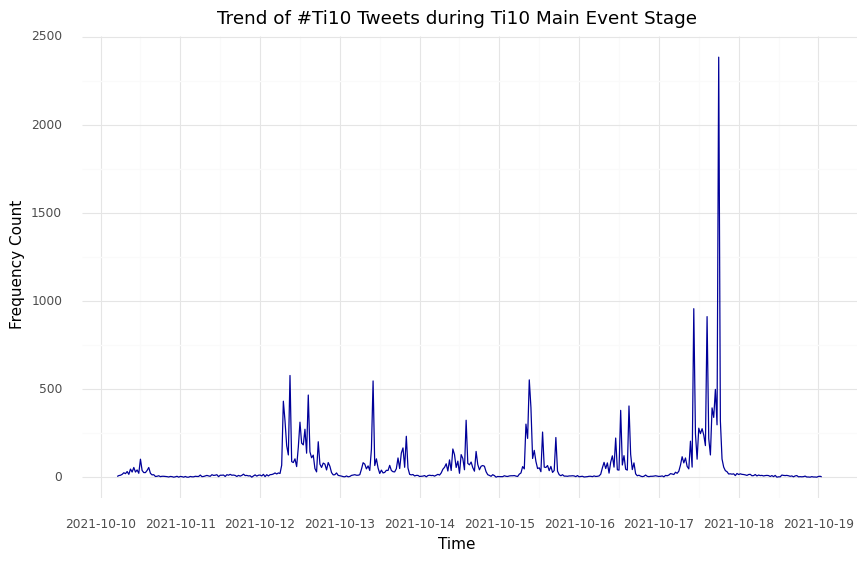

<ggplot: (8783829075169)>

In [196]:
#p = \
(
    ggplot(aes(x = "created_at", y = "number_of_tweet"), data= time_df)
    +geom_line(color = "#000099")
    +theme_minimal()
    +theme(figure_size=(10, 6))
    #+theme(axis_text_x=element_text(angle=45))
    +labs(
        title = "Trend of #Ti10 Tweets during Ti10 Main Event Stage",
        x = "Time",
        y = "Frequency Count")
   
  )
#p.save(filename = 'tweet_trend.png', dpi = 300)

In [53]:
from wordcloud import WordCloud, STOPWORDS

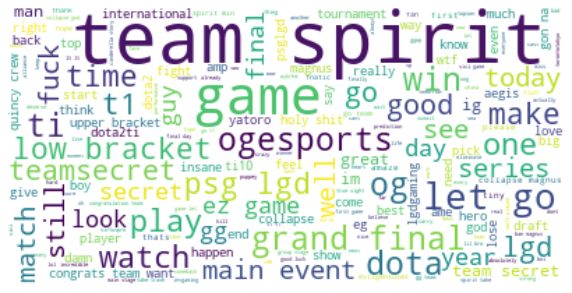

In [52]:
# generate a word cloud
plt.figure(figsize=(10,8))
text = " ".join(twt for twt in test_df['lemmatized_text'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [54]:
# Distribution of number of words in the 
original_count = en_ti10.text.astype(str).apply(lambda x: x.split(" ")).apply(len)


In [55]:
original_count_df =pd.DataFrame(original_count)
original_count_df["original"] = "True"
original_count_df

text original
1        19     True
2        21     True
3        11     True
4         6     True
5         7     True
...     ...      ...
41832    32     True
41833    49     True
41836    18     True
41837    31     True
41838    31     True

[26839 rows x 2 columns]

In [56]:
original_count_df.text.describe()

count    26839.000000
mean        12.999404
std         10.422851
min          1.000000
25%          6.000000
50%          9.000000
75%         17.000000
max        180.000000
Name: text, dtype: float64

In [57]:
original_count_df.text.mean()

12.999403852602557

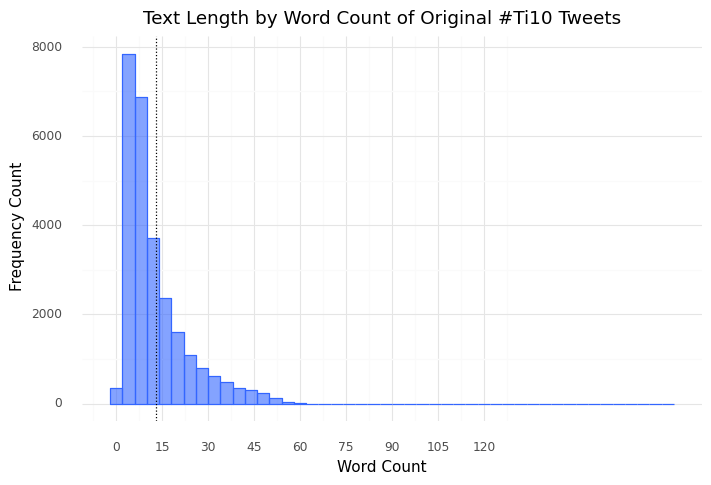

<ggplot: (8783829237693)>

In [194]:
#p = \
(
    ggplot(aes(x = "text", color = 'original', fill = 'original'), data= original_count_df)
    +geom_histogram(binwidth = 4, alpha = 0.6)
    +geom_vline(xintercept = original_count_df.text.mean(), linetype = "dotted")
    +theme_minimal()
    +theme(figure_size=(8, 5), legend_position="none")
    +labs(
        title = "Text Length by Word Count of Original #Ti10 Tweets",
        x = "Word Count",
        y = "Frequency Count",
        captions = "Dotted line represents mean #Ti10 tweet word count")
    +scale_x_continuous(breaks = [0,15,30,45,60,75,90,105,120])
    +scale_color_manual(values = "#3366FF")
    +scale_fill_manual(values = '#3366FF')
   
  )
#p.save(filename = 'text_length_by_word_count.png', dpi = 300)

In [59]:
common_text = " ".join(en_ti10.lemmatized_text.astype(str).tolist())
common_words = common_text.split(sep = " ")
top_20 = pd.DataFrame(Counter(common_words).most_common(20), columns = ['word', 'frequency'])
top_20 = top_20.sort_values(by = 'frequency')
top_20

word  frequency
19       day       1033
18  collapse       1046
17    secret       1076
16         1       1085
15   bracket       1133
14        og       1261
13       get       1310
12       lgd       1339
11      dota       1442
10        t1       1450
9         ti       1470
8          v       1488
7        win       1580
6      final       1622
5          2       1677
4        let       1868
3         go       2466
2       game       4903
1     spirit       5791
0       team       7355

In [60]:
word_cat = pd.Categorical(top_20['word'], categories=top_20['word'])

# assign to a new column in the DataFrame
top_20 = top_20.assign(word_cat = word_cat)

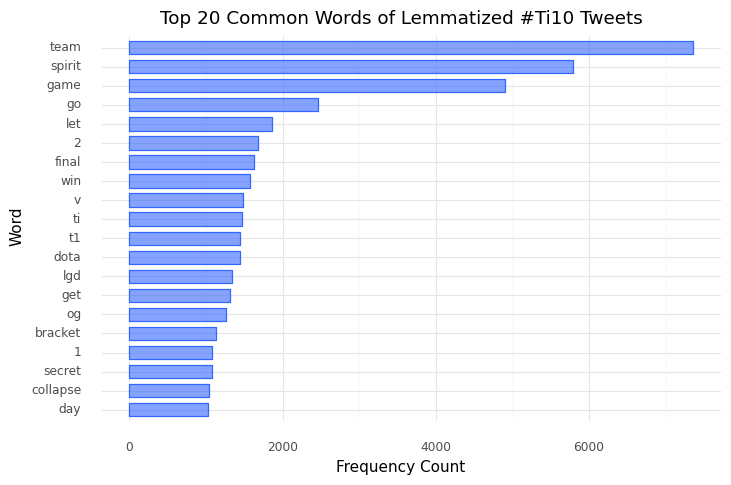

<ggplot: (8783829230429)>

In [192]:
#p = \
(
    ggplot(aes(x = "word_cat", y = 'frequency'), data= top_20)
    +geom_col(alpha = 0.6, color = '#3366ff', fill = '#3366ff', width = 0.7)
    +theme_minimal()
    +theme(figure_size=(8, 5), legend_position="none")
    +labs(
        title = "Top 20 Common Words of Lemmatized #Ti10 Tweets",
        x = "Word",
        y = "Frequency Count")
    +coord_flip()
    #+scale_color_manual(values = "#3366FF")
    #+scale_fill_manual(values = '#3366FF')
  )
#p.save(filename = 'top_lemmatized_word.png', dpi=300)

## **LDA** 

Find optimal number of topics for LDA: Coherence vs. Jaccard

In [39]:
# create dictionary
id2word = corpora.Dictionary(en_ti10.clean_text_token)

# create corpus
texts = en_ti10.clean_text_token

# term document frequeny
corpus = [id2word.doc2bow(text) for text in texts]

In [40]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [41]:
from gensim.models import LdaMulticore as LdaModel

In [42]:
# Considering 2-15 topics (~5min executing time)
num_topics = list(range(16)[2:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = LdaModel(corpus=corpus,
                             id2word=id2word,
                             num_topics=i,
                             random_state=33)

    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [43]:
# Coherence matrix
from gensim.models import CoherenceModel
coherences = [CoherenceModel(model=LDA_models[i], texts=en_ti10.clean_text_token, dictionary=id2word, coherence='c_v').get_coherence()\
              for i in num_topics[:-1]]

In [44]:
# derive the mean stability across topics by considering the next topic:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [45]:
# derive the ideal number of topics roughly through the difference between the coherence and stability per number of topics
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords-1)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
#ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
#ideal_topic_num = num_topics[ideal_topic_num_index]

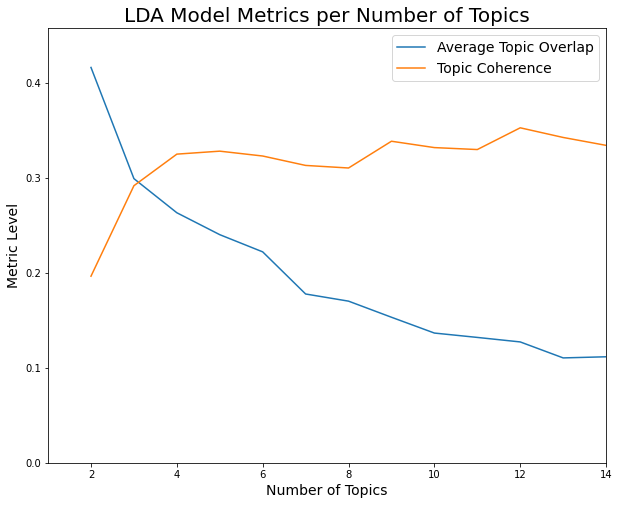

In [46]:
# graph these metrics across the topic numbers
plt.figure(figsize=(10,8))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

#ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
#ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('LDA Model Metrics per Number of Topics', fontsize=20)
ax.set_ylabel('Metric Level', fontsize=14)
ax.set_xlabel('Number of Topics', fontsize=14)
plt.legend(fontsize=14)
plt.show() 

The best LDA model has 4 topics

In [200]:
# number of topics
num_topics = 4

# Build the best LDA model
best_model = gensim.models.LdaMulticore(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=num_topics,
                                      random_state=33)

In [209]:
from gensim.models import CoherenceModel
coherences = CoherenceModel(model=best_model, texts=en_ti10.clean_text_token, dictionary=id2word, coherence='c_v').get_coherence()

In [210]:
# best model coherence score
coherences

0.325432525556042

In [218]:
# best model stablility
mean_stabilities[3]

0.24004786326373215

In [206]:
# best model perplexity
best_model.log_perplexity(corpus)

-7.513681257040492

In [71]:
pprint(best_model.show_topics(num_topics=4,num_words=20))

[(0,
  '0.025*"game" + 0.022*"bracket" + 0.020*"go" + 0.019*"v" + 0.017*"ogesports" '
  '+ 0.017*"main" + 0.016*"event" + 0.016*"2" + 0.015*"let" + 0.014*"t1" + '
  '0.013*"day" + 0.012*"1" + 0.011*"time" + 0.010*"teamsecret" + 0.010*"og" + '
  '0.009*"upper" + 0.008*"low" + 0.008*"first" + 0.008*"get" + 0.008*"ti"'),
 (1,
  '0.032*"let" + 0.031*"go" + 0.026*"team" + 0.019*"t1" + 0.016*"spirit" + '
  '0.014*"eg" + 0.014*"fuck" + 0.011*"god" + 0.008*"win" + 0.007*"play" + '
  '0.007*"lgd" + 0.006*"game" + 0.006*"get" + 0.005*"hype" + 0.005*"dota" + '
  '0.005*"elephant" + 0.005*"ceremony" + 0.005*"magnus" + 0.005*"feel" + '
  '0.005*"collapse"'),
 (2,
  '0.025*"game" + 0.010*"na" + 0.010*"like" + 0.009*"watch" + 0.009*"good" + '
  '0.009*"get" + 0.009*"look" + 0.008*"play" + 0.007*"ti" + 0.007*"stage" + '
  '0.007*"dota" + 0.007*"see" + 0.007*"im" + 0.006*"gon" + 0.006*"one" + '
  '0.006*"main" + 0.005*"love" + 0.005*"prediction" + 0.005*"make" + '
  '0.005*"holy"'),
 (3,
  '0.054*"team

In [ ]:
!pip install pyLDAvis

In [146]:
import pyLDAvis
import pyLDAvis.gensim_models

In [73]:
topics = best_model.show_topics()
for topic in topics:
  print(topic)

(0, '0.025*"game" + 0.022*"bracket" + 0.020*"go" + 0.019*"v" + 0.017*"ogesports" + 0.017*"main" + 0.016*"event" + 0.016*"2" + 0.015*"let" + 0.014*"t1"')
(1, '0.032*"let" + 0.031*"go" + 0.026*"team" + 0.019*"t1" + 0.016*"spirit" + 0.014*"eg" + 0.014*"fuck" + 0.011*"god" + 0.008*"win" + 0.007*"play"')
(2, '0.025*"game" + 0.010*"na" + 0.010*"like" + 0.009*"watch" + 0.009*"good" + 0.009*"get" + 0.009*"look" + 0.008*"play" + 0.007*"ti" + 0.007*"stage"')
(3, '0.054*"team" + 0.027*"spirit" + 0.020*"og" + 0.019*"secret" + 0.013*"dota" + 0.012*"game" + 0.011*"ti" + 0.010*"international" + 0.009*"quincy" + 0.009*"year"')


In [74]:
test_df['topic_prob'] = best_model.get_document_topics(corpus)
test_df.head()

user_id             status_id          created_at  \
41838            x529762523  x1447061771643076610 2021-10-10 05:00:00   
41837            x529762523  x1447061771643076610 2021-10-10 05:00:00   
37662           x3814210037  x1447064350683025408 2021-10-10 05:00:00   
41836   x928966458628915200  x1447066196403122178 2021-10-10 05:00:00   
34689  x1352227175257284624  x1447067991330340865 2021-10-10 05:00:00   

          screen_name                                               text  \
41838  VortexContinum  @BladeRnnrQuote @copperbottomus We agree. Huma...   
41837  VortexContinum  @BladeRnnrQuote @copperbottomus We agree. Huma...   
37662    Team__Spirit  Schedule for the last day of #TI10 Group Stage...   
41836   stickman_o_o_  How are they gonna put crowd scenes in true si...   
34689       SuperPOG_  Picks for #TI10's last day of the group stage ...   

                    source  display_text_width    reply_to_status_id  \
41838  Twitter for Android                 206  x1446973762197393408   
41837  Twitter for Android                 206  x1446973762197393408   
37662      Twitter Web App                  72                   NaN   
41836  Twitter for Android                  98                   NaN   
34689  Twitter for Android                  82                   NaN   

           reply_to_user_id reply_to_screen_name  is_quote  is_retweet  \
41838  x1279004605289037825       BladeRnnrQuote     False       False   
41837  x1279004605289037825       BladeRnnrQuote     False       False   
37662                   NaN                  NaN     False       False   
41836                   NaN                  NaN     False       False   
34689                   NaN                  NaN     False       False   

       favorite_count  retweet_count  quote_count  reply_count  \
41838               0              0          NaN          NaN   
41837               0              0          NaN          NaN   
37662              36              4          NaN          NaN   
41836               0              0          NaN          NaN   
34689               1              0          NaN          NaN   

                                                hashtags symbols urls_url  \
41838  Covid_19 covid time travel WarpDrive HyperLigh...     NaN      NaN   
41837  Covid_19 covid time travel WarpDrive HyperLigh...     NaN      NaN   
37662                           TI10 SPIRITIX SpiritDota     NaN      NaN   
41836                                 dota2TI TI10 Dota2     NaN      NaN   
34689                                               TI10     NaN      NaN   

      urls_t.co urls_expanded_url  \
41838       NaN               NaN   
41837       NaN               NaN   
37662       NaN               NaN   
41836       NaN               NaN   
34689       NaN               NaN   

                                            media_url  \
41838                                             NaN   
41837                                             NaN   
37662  http://pbs.twimg.com/media/FBR2TBSWUBgVZXw.jpg   
41836                                             NaN   
34689                                             NaN   

                    media_t.co  \
41838                      NaN   
41837                      NaN   
37662  https://t.co/7BBXe6P51V   
41836                      NaN   
34689                      NaN   

                                      media_expanded_url media_type  \
41838                                                NaN        NaN   
41837                                                NaN        NaN   
37662  https://twitter.com/Team__Spirit/status/144706...      photo   
41836                                                NaN        NaN   
34689                                                NaN        NaN   

                                        ext_media_url  \
41838                                             NaN   
41837                                             NaN   
37662  http://pbs

In [75]:
test_df.topic_prob.head()

41838    [(0, 0.11618798), (1, 0.26385474), (2, 0.30340...
41837    [(0, 0.031720713), (1, 0.03216022), (2, 0.9036...
37662    [(0, 0.05028117), (1, 0.4411395), (2, 0.051261...
41836    [(0, 0.12503986), (1, 0.60728335), (2, 0.13735...
34689    [(0, 0.05095561), (1, 0.044749554), (2, 0.0431...
Name: topic_prob, dtype: object

In [76]:
test_df['main_topic'] = [int(str(sorted(best_model[i],reverse=True,key=lambda x: x[1])[0][0]).zfill(3)) for i in corpus]

In [77]:
test_df['main_topic_prob'] = [float(str(sorted(best_model[i],reverse=True,key=lambda x: x[1])[0][1]).zfill(3)) for i in corpus]
test_df['main_topic_prob'].head()

41838    0.316602
41837    0.903582
37662    0.457869
41836    0.607397
34689    0.860935
Name: main_topic_prob, dtype: float64

In [78]:
test_df[test_df['main_topic'] == 0].sort_values(by = 'main_topic_prob', ascending = False).text.head()

32654    Absolutely gutted for the Aster squad. They ha...
1182     Now more than ever during this game 5 finisher...
29868    @FNATIC @cryptocom Congrats on your playoff wi...
29885    CONFIRMED: We will play against @TeamAsterCN i...
29082    No Dota playin people that can relate to my tw...
Name: text, dtype: object

In [79]:
test_df[test_df['main_topic'] == 0].sort_values(by = 'main_topic_prob', ascending = False)

user_id             status_id          created_at  \
32654            x235111392  x1447980516641161217 2021-10-12 17:30:00   
1182             x545587616  x1449781772011462660 2021-10-17 17:00:00   
29868   x897121291467149313  x1448230530856755201 2021-10-13 10:00:00   
29885  x1394780487252471809  x1447204780166811655 2021-10-10 14:30:00   
29082   x934226453734023169  x1448406107861491718 2021-10-13 22:00:00   
...                     ...                   ...                 ...   
2818              x83820103  x1449805050222505985 2021-10-17 18:30:00   
31206           x1124889985  x1447903534826102785 2021-10-12 12:30:00   
23120           x2905106691  x1448356936936787968 2021-10-13 18:30:00   
5268             x986942456  x1449796717621121028 2021-10-17 18:00:00   
35045             x31925746  x1447170706509230082 2021-10-10 12:00:00   

           screen_name                                               text  \
32654        hancholoo  Absolutely gutted for the Aster squad. They ha...   
1182   wickedplayer494  Now more than ever during this game 5 finisher...   
29868       pmbrsantos  @FNATIC @cryptocom Congrats on your playoff wi...   
29885      Quincy_Crew  CONFIRMED: We will play against @TeamAsterCN i...   
29082     usmanouthere  No Dota playin people that can relate to my tw...   
...                ...                                                ...   
2818          iboqibor  new legend of magnus!! #TI10  @Team__Spirit ht...   
31206         ESLDota2                     HERE WE GO! #TI10 <U+0001F525>   
23120        sfprTrell  yawar: look into my eyes, brother\r\nyawar: im...   
5268       ariffmahmud  Feels so bad for Ame. Sama taraf dgn w33haa. A...   
35045       drbuttocks         Vici playing like they're a pubstack #TI10   

                    source  display_text_width    reply_to_status_id  \
32654  Twitter for Android                 257                   NaN   
1182             TweetDeck                 164                   NaN   
29868  Twitter for Android                  65  x1448213523310551046   
29885            TweetDeck                  89                   NaN   
29082   Twitter for iPhone                  59                   NaN   
...                    ...                 ...                   ...   
2818       Twitter Web App                  43                   NaN   
31206            TweetDeck                  19                   NaN   
23120      Twitter Web App                  95                   NaN   
5268   Twitter for Android                  77                   NaN   
35045            TweetDeck                  42                   NaN   

      reply_to_user_id reply_to_screen_name  is_quote  is_retweet  \
32654              NaN                  NaN     False       False   
1182               NaN                  NaN     False       False   
29868        x19976791               FNATIC     False       False   
29885              NaN                  NaN     False       False   
29082              NaN                  NaN     False       False   
...                ...                  ...       ...         ...   
2818               NaN                  NaN      True       False   
31206              NaN                  NaN     False       False   
23120              NaN                  NaN     False       False   
5268               NaN                  NaN     False       False   
35045              NaN                  NaN     False       False   

       favorite_count  retweet_count  quote_count  reply_count  \
32654               1              0          NaN          NaN   
1182                1              0          NaN          NaN   
29868               1              0          NaN          NaN   
29885             181              4          NaN          NaN   
29082               1              0          NaN          NaN   
...               ...            ...          ...          ...   
2818                0              0          NaN          NaN

In [80]:
test_df.to_csv("lda_with_topic_lable.csv")

In [88]:
check_v = test_df[test_df['lemmatized_text'].str.contains('v')].text

In [96]:
test_df[test_df['lemmatized_text'].str.contains('v')].text

35116    #TI10 Group A projected wins post Day 3:\r\n\r...
35113    #TI10 Group B projected wins, post Day 3:\r\n\...
41833    iG looking absolutely sick heading into the la...
41832    T1 vs Undying | 23savage Tiny Divine Rapier Th...
31031    all of these #TI10 hypes make me want to go ba...
                               ...                        
33       New Esports Minute with our host @Correa24 <U+...
9        Still feels like #TI10 has concluded 2 hours a...
32       The only one I managed to win, thanks to bulba...
28       Just can’t wait to have that collab with @Tiwa...
1        Miposhka shared in the team's vlog what really...
Name: text, Length: 7936, dtype: object

In [47]:
lda_ti10 = pd.read_csv('lda_with_topic_lable.csv', encoding = 'utf-8')

In [49]:
lda_ti10.main_topic.value_counts()

3    6890
2    6759
0    6742
1    6448
Name: main_topic, dtype: int64

## **NMF**

In [ ]:
from gensim.models import Nmf

In [97]:
# Considering 2-15 topics
num_topics = list(range(16)[2:])
num_keywords = 15

NMF_models = {}
NMF_topics = {}
for i in num_topics:
    NMF_models[i] = Nmf(corpus=corpus,
                             id2word=id2word,
                             num_topics=i,
                             random_state=33)

    shown_topics = NMF_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    NMF_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [98]:
# Coherence matrix
coherences = [CoherenceModel(model=NMF_models[i], texts=en_ti10.clean_text_token, dictionary=id2word, coherence='c_v').get_coherence()\
              for i in num_topics[:-1]]

In [101]:
# nmf best model stability at 0.2509545482558976
mean_stabilities

[0.3382771912183677,
 0.2509545482558976,
 0.2058310817118913,
 0.16587810046580662,
 0.16094815492719924,
 0.14852300840946556,
 0.1391171409568461,
 0.12246989433777618,
 0.11763274119862571,
 0.11506887608325525,
 0.09567265332383339,
 0.09079197195743319,
 0.09610165959062608]

In [100]:
# derive the mean stability across topics by considering the next topic:
NMF_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(NMF_topics[num_topics[i]]): # pylint: disable=unused-variable
        sims = []
        for t2, topic2 in enumerate(NMF_topics[num_topics[i+1]]): # pylint: disable=unused-variable
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    NMF_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(NMF_stability[i]).mean() for i in num_topics[:-1]]

In [102]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords-1)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

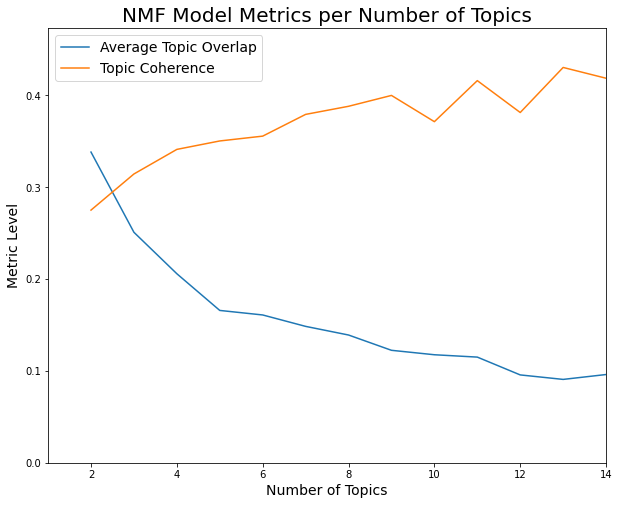

In [107]:
plt.figure(figsize=(10,8))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

#ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
#ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('NMF Model Metrics per Number of Topics', fontsize=20)
ax.set_ylabel('Metric Level', fontsize=14)
ax.set_xlabel('Number of Topics', fontsize=14)
plt.legend(fontsize=14)
plt.show()

The best nmf model has 3 topics

In [219]:
# number of topics 
num_topics = 3

# Build the best LDA model
nmf_best_model = gensim.models.Nmf(corpus=corpus,
                                      id2word=id2word,
                                      num_topics=num_topics,
                                      random_state=33)

In [221]:
# nmf best model coherence
coherences = CoherenceModel(model=nmf_best_model, texts=en_ti10.clean_text_token, dictionary=id2word, coherence='c_v').get_coherence()
coherences

0.3144236639666341

In [109]:
pprint(nmf_best_model.show_topics(num_topics=3,num_words=20))

[(0,
  '0.167*"team" + 0.141*"spirit" + 0.013*"magnus" + 0.011*"go" + '
  '0.010*"congrats" + 0.009*"champion" + 0.007*"play" + 0.007*"gg" + '
  '0.007*"take" + 0.007*"collapse" + 0.006*"v" + 0.006*"run" + 0.006*"win" + '
  '0.006*"ban" + 0.006*"let" + 0.006*"aegis" + 0.005*"congratulation" + '
  '0.005*"secret" + 0.005*"like" + 0.005*"well"'),
 (1,
  '0.025*"ti" + 0.023*"win" + 0.023*"final" + 0.023*"lgd" + 0.013*"bracket" + '
  '0.013*"day" + 0.013*"psg" + 0.012*"v" + 0.011*"go" + 0.010*"secret" + '
  '0.010*"t1" + 0.010*"grand" + 0.010*"get" + 0.009*"time" + 0.009*"2" + '
  '0.008*"og" + 0.007*"one" + 0.007*"low" + 0.007*"let" + 0.007*"dota"'),
 (2,
  '0.146*"game" + 0.028*"5" + 0.025*"2" + 0.018*"1" + 0.014*"hype" + '
  '0.013*"dota" + 0.012*"3" + 0.011*"go" + 0.010*"v" + 0.010*"ez" + '
  '0.009*"final" + 0.009*"let" + 0.008*"t1" + 0.007*"vici" + 0.006*"good" + '
  '0.006*"get" + 0.005*"grand" + 0.005*"best" + 0.005*"watch" + 0.005*"take"')]


In [222]:
topics = nmf_best_model.show_topics()
for topic in topics:
  print(topic)

(0, '0.167*"team" + 0.141*"spirit" + 0.013*"magnus" + 0.011*"go" + 0.010*"congrats" + 0.009*"champion" + 0.007*"play" + 0.007*"gg" + 0.007*"take" + 0.007*"collapse"')
(1, '0.025*"ti" + 0.023*"win" + 0.023*"final" + 0.023*"lgd" + 0.013*"bracket" + 0.013*"day" + 0.013*"psg" + 0.012*"v" + 0.011*"go" + 0.010*"secret"')
(2, '0.146*"game" + 0.028*"5" + 0.025*"2" + 0.018*"1" + 0.014*"hype" + 0.013*"dota" + 0.012*"3" + 0.011*"go" + 0.010*"v" + 0.010*"ez"')


In [223]:
test_df['topic_prob'] = nmf_best_model.get_document_topics(corpus, minimum_probability=0.00001)
test_df.head()

user_id             status_id          created_at  \
41838            x529762523  x1447061771643076610 2021-10-10 05:00:00   
41837            x529762523  x1447061771643076610 2021-10-10 05:00:00   
37662           x3814210037  x1447064350683025408 2021-10-10 05:00:00   
41836   x928966458628915200  x1447066196403122178 2021-10-10 05:00:00   
34689  x1352227175257284624  x1447067991330340865 2021-10-10 05:00:00   

          screen_name                                               text  \
41838  VortexContinum  @BladeRnnrQuote @copperbottomus We agree. Huma...   
41837  VortexContinum  @BladeRnnrQuote @copperbottomus We agree. Huma...   
37662    Team__Spirit  Schedule for the last day of #TI10 Group Stage...   
41836   stickman_o_o_  How are they gonna put crowd scenes in true si...   
34689       SuperPOG_  Picks for #TI10's last day of the group stage ...   

                    source  display_text_width    reply_to_status_id  \
41838  Twitter for Android                 206  x1446973762197393408   
41837  Twitter for Android                 206  x1446973762197393408   
37662      Twitter Web App                  72                   NaN   
41836  Twitter for Android                  98                   NaN   
34689  Twitter for Android                  82                   NaN   

           reply_to_user_id reply_to_screen_name  is_quote  is_retweet  \
41838  x1279004605289037825       BladeRnnrQuote     False       False   
41837  x1279004605289037825       BladeRnnrQuote     False       False   
37662                   NaN                  NaN     False       False   
41836                   NaN                  NaN     False       False   
34689                   NaN                  NaN     False       False   

       favorite_count  retweet_count  quote_count  reply_count  \
41838               0              0          NaN          NaN   
41837               0              0          NaN          NaN   
37662              36              4          NaN          NaN   
41836               0              0          NaN          NaN   
34689               1              0          NaN          NaN   

                                                hashtags symbols urls_url  \
41838  Covid_19 covid time travel WarpDrive HyperLigh...     NaN      NaN   
41837  Covid_19 covid time travel WarpDrive HyperLigh...     NaN      NaN   
37662                           TI10 SPIRITIX SpiritDota     NaN      NaN   
41836                                 dota2TI TI10 Dota2     NaN      NaN   
34689                                               TI10     NaN      NaN   

      urls_t.co urls_expanded_url  \
41838       NaN               NaN   
41837       NaN               NaN   
37662       NaN               NaN   
41836       NaN               NaN   
34689       NaN               NaN   

                                            media_url  \
41838                                             NaN   
41837                                             NaN   
37662  http://pbs.twimg.com/media/FBR2TBSWUBgVZXw.jpg   
41836                                             NaN   
34689                                             NaN   

                    media_t.co  \
41838                      NaN   
41837                      NaN   
37662  https://t.co/7BBXe6P51V   
41836                      NaN   
34689                      NaN   

                                      media_expanded_url media_type  \
41838                                                NaN        NaN   
41837                                                NaN        NaN   
37662  https://twitter.com/Team__Spirit/status/144706...      photo   
41836                                                NaN        NaN   
34689                                                NaN        NaN   

                                        ext_media_url  \
41838                                             NaN   
41837                                             NaN   
37662  http://pbs

In [224]:
# notice that every topic probabilities are not assign to certain document, so need manual assignment
test_df.topic_prob[2]

[(1, 0.9819205617582458), (2, 0.018079438241754217)]

In [225]:
# assign probability to 0 of missing topics (gensim fails to assign the zero probability in Nmf model)
# since the optimal number of topics is only 3, could simply exhaust all combinations
def assign_zero_prob(assign_zero):
  if len(assign_zero) == 3:
    assign_zero == assign_zero
  elif len(assign_zero) == 2:
    if assign_zero[0][0] == 0 and assign_zero[1][0] == 1:
      assign_zero.append((2,0))
    if assign_zero[0][0] == 0 and assign_zero[1][0] == 2:
      assign_zero.append((1,0))
    if assign_zero[0][0] == 1 and assign_zero[1][0] == 2:
      assign_zero.append((0,0))
  elif len(assign_zero) == 1:
    if assign_zero[0][0] == 0:
      assign_zero.append((1,0))
      assign_zero.append((2,0))
    if assign_zero[0][0] == 1:
      assign_zero.append((0,0))
      assign_zero.append((2,0))
    if assign_zero[0][0] == 2:
      assign_zero.append((0,0))
      assign_zero.append((1,0))
  else:
    assign_zero = []
    # if not topic assign, evenly assign the probability
    assign_zero.append((0,0.3334))
    assign_zero.append((1,0.3333))
    assign_zero.append((2,0.3333))
  return assign_zero


In [226]:
test_df['topic_prob'] = test_df['topic_prob'].apply(assign_zero_prob)

In [227]:
test_df.topic_prob[2]

[(1, 0.9819205617582458), (2, 0.018079438241754217), (0, 0)]

In [239]:
# reorder the list
test_df['topic_prob']= test_df['topic_prob'].apply(sorted)

In [241]:
# assign the document topic label corresponding to the highest probability
def assign_topic_label(find_prob):
  for i in range(0, len(find_prob)):
    max_prob = max([prob[1] for prob in find_prob])
    if find_prob[i][1] == max_prob:
      return i

In [242]:
# assign the document main topic probability
def assign_main_prob(find_prob):
  for i in range(0, len(find_prob)):
    max_prob = max([prob[1] for prob in find_prob])
    if find_prob[i][1] == max_prob:
      return find_prob[i][1]

In [243]:
test_df['main_topic'] = test_df['topic_prob'].apply(assign_topic_label)

In [244]:
test_df['main_topic_prob'] = test_df['topic_prob'].apply(assign_main_prob)

In [245]:
test_df.head()

user_id             status_id          created_at  \
41838            x529762523  x1447061771643076610 2021-10-10 05:00:00   
41837            x529762523  x1447061771643076610 2021-10-10 05:00:00   
37662           x3814210037  x1447064350683025408 2021-10-10 05:00:00   
41836   x928966458628915200  x1447066196403122178 2021-10-10 05:00:00   
34689  x1352227175257284624  x1447067991330340865 2021-10-10 05:00:00   

          screen_name                                               text  \
41838  VortexContinum  @BladeRnnrQuote @copperbottomus We agree. Huma...   
41837  VortexContinum  @BladeRnnrQuote @copperbottomus We agree. Huma...   
37662    Team__Spirit  Schedule for the last day of #TI10 Group Stage...   
41836   stickman_o_o_  How are they gonna put crowd scenes in true si...   
34689       SuperPOG_  Picks for #TI10's last day of the group stage ...   

                    source  display_text_width    reply_to_status_id  \
41838  Twitter for Android                 206  x1446973762197393408   
41837  Twitter for Android                 206  x1446973762197393408   
37662      Twitter Web App                  72                   NaN   
41836  Twitter for Android                  98                   NaN   
34689  Twitter for Android                  82                   NaN   

           reply_to_user_id reply_to_screen_name  is_quote  is_retweet  \
41838  x1279004605289037825       BladeRnnrQuote     False       False   
41837  x1279004605289037825       BladeRnnrQuote     False       False   
37662                   NaN                  NaN     False       False   
41836                   NaN                  NaN     False       False   
34689                   NaN                  NaN     False       False   

       favorite_count  retweet_count  quote_count  reply_count  \
41838               0              0          NaN          NaN   
41837               0              0          NaN          NaN   
37662              36              4          NaN          NaN   
41836               0              0          NaN          NaN   
34689               1              0          NaN          NaN   

                                                hashtags symbols urls_url  \
41838  Covid_19 covid time travel WarpDrive HyperLigh...     NaN      NaN   
41837  Covid_19 covid time travel WarpDrive HyperLigh...     NaN      NaN   
37662                           TI10 SPIRITIX SpiritDota     NaN      NaN   
41836                                 dota2TI TI10 Dota2     NaN      NaN   
34689                                               TI10     NaN      NaN   

      urls_t.co urls_expanded_url  \
41838       NaN               NaN   
41837       NaN               NaN   
37662       NaN               NaN   
41836       NaN               NaN   
34689       NaN               NaN   

                                            media_url  \
41838                                             NaN   
41837                                             NaN   
37662  http://pbs.twimg.com/media/FBR2TBSWUBgVZXw.jpg   
41836                                             NaN   
34689                                             NaN   

                    media_t.co  \
41838                      NaN   
41837                      NaN   
37662  https://t.co/7BBXe6P51V   
41836                      NaN   
34689                      NaN   

                                      media_expanded_url media_type  \
41838                                                NaN        NaN   
41837                                                NaN        NaN   
37662  https://twitter.com/Team__Spirit/status/144706...      photo   
41836                                                NaN        NaN   
34689                                                NaN        NaN   

                                        ext_media_url  \
41838                                             NaN   
41837                                             NaN   
37662  http://pbs

In [201]:
test_df.topic_prob.apply(len).sort_values().value_counts()

3    26839
Name: topic_prob, dtype: int64

In [260]:
test_df.to_csv("nmf_with_topic_lable.csv")

In [269]:
investigate_df = test_df[test_df['main_topic'] == 2].sort_values(by = 'main_topic_prob', ascending = False)

In [271]:
investigate_df[(investigate_df['main_topic_prob'] < 0.9) & (investigate_df['lemma_text_length'] >10)].text.head()

16911    <U+0001F642><U+0001F642><U+0001F642>great figh...
9741     smooth like butter baby, looking good for our ...
23530    HOLY FUCK MARCI :D &lt;3 &lt;3 &lt;3 &lt;3 &lt...
7719     And suddenly, I do not mind losing 100 @strafe...
13346    As @Team__Spirit make their way to the #TI10 f...
Name: text, dtype: object

In [258]:
test_df['lemma_text_length'] = test_df.clean_text_token.apply(len)

In [259]:
test_df.head()

user_id             status_id          created_at  \
41838            x529762523  x1447061771643076610 2021-10-10 05:00:00   
41837            x529762523  x1447061771643076610 2021-10-10 05:00:00   
37662           x3814210037  x1447064350683025408 2021-10-10 05:00:00   
41836   x928966458628915200  x1447066196403122178 2021-10-10 05:00:00   
34689  x1352227175257284624  x1447067991330340865 2021-10-10 05:00:00   

          screen_name                                               text  \
41838  VortexContinum  @BladeRnnrQuote @copperbottomus We agree. Huma...   
41837  VortexContinum  @BladeRnnrQuote @copperbottomus We agree. Huma...   
37662    Team__Spirit  Schedule for the last day of #TI10 Group Stage...   
41836   stickman_o_o_  How are they gonna put crowd scenes in true si...   
34689       SuperPOG_  Picks for #TI10's last day of the group stage ...   

                    source  display_text_width    reply_to_status_id  \
41838  Twitter for Android                 206  x1446973762197393408   
41837  Twitter for Android                 206  x1446973762197393408   
37662      Twitter Web App                  72                   NaN   
41836  Twitter for Android                  98                   NaN   
34689  Twitter for Android                  82                   NaN   

           reply_to_user_id reply_to_screen_name  is_quote  is_retweet  \
41838  x1279004605289037825       BladeRnnrQuote     False       False   
41837  x1279004605289037825       BladeRnnrQuote     False       False   
37662                   NaN                  NaN     False       False   
41836                   NaN                  NaN     False       False   
34689                   NaN                  NaN     False       False   

       favorite_count  retweet_count  quote_count  reply_count  \
41838               0              0          NaN          NaN   
41837               0              0          NaN          NaN   
37662              36              4          NaN          NaN   
41836               0              0          NaN          NaN   
34689               1              0          NaN          NaN   

                                                hashtags symbols urls_url  \
41838  Covid_19 covid time travel WarpDrive HyperLigh...     NaN      NaN   
41837  Covid_19 covid time travel WarpDrive HyperLigh...     NaN      NaN   
37662                           TI10 SPIRITIX SpiritDota     NaN      NaN   
41836                                 dota2TI TI10 Dota2     NaN      NaN   
34689                                               TI10     NaN      NaN   

      urls_t.co urls_expanded_url  \
41838       NaN               NaN   
41837       NaN               NaN   
37662       NaN               NaN   
41836       NaN               NaN   
34689       NaN               NaN   

                                            media_url  \
41838                                             NaN   
41837                                             NaN   
37662  http://pbs.twimg.com/media/FBR2TBSWUBgVZXw.jpg   
41836                                             NaN   
34689                                             NaN   

                    media_t.co  \
41838                      NaN   
41837                      NaN   
37662  https://t.co/7BBXe6P51V   
41836                      NaN   
34689                      NaN   

                                      media_expanded_url media_type  \
41838                                                NaN        NaN   
41837                                                NaN        NaN   
37662  https://twitter.com/Team__Spirit/status/144706...      photo   
41836                                                NaN        NaN   
34689                                                NaN        NaN   

                                        ext_media_url  \
41838                                             NaN   
41837                                             NaN   
37662  http://pbs

In [50]:
nmf_ti10 = pd.read_csv('nmf_with_topic_lable.csv', encoding = 'utf-8')

In [51]:
nmf_ti10.main_topic.value_counts()

1.0    14300
0.0     5831
2.0     4441
Name: main_topic, dtype: int64

In [53]:
nmf_ti10.main_topic.unique()

array([ 0.,  1.,  2., nan])

## **BTM**

In [277]:
import bitermplus as btm

In [66]:
# PREPROCESSING
# Obtaining terms frequency in a sparse matrix and corpus vocabulary
texts = test_df['lemmatized_text'].str.strip().tolist()
X, vocabulary, vocab_dict = btm.get_words_freqs(texts)
tf = np.array(X.sum(axis=0)).ravel()
# Vectorizing documents
docs_vec = btm.get_vectorized_docs(texts, vocabulary)
docs_lens = list(map(len, docs_vec))
# Generating biterms
biterms = btm.get_biterms(docs_vec)

In [67]:
# find the optimal number of topics according to perplexity & coherence
# Considering 2-15 topics
num_topics = list(range(16)[2:])
num_keywords = 20

btm_models = {}
perplexity_list =[]
coherence_list = []
for i in num_topics:
    btm_models[i] = btm.BTM(X, vocabulary, seed=97116, T=i, M=num_keywords)
    btm_models[i].fit(biterms, iterations=20)
    p_zd = btm_models[i].transform(docs_vec)
    perplexity = btm.perplexity(btm_models[i].matrix_topics_words_, p_zd, X, i)
    coherence = btm.coherence(btm_models[i].matrix_topics_words_, X, M=20)
    perplexity_list.append(perplexity)
    coherence_list.append(coherence)

100%|██████████| 26839/26839 [00:00<00:00, 106659.13it/s]


In [68]:
coherence_list

[array([-551.50685941, -555.15976954]),
 array([-546.34345163, -623.52520886, -544.75547555]),
 array([-538.05649907, -580.34532264, -575.5661061 , -554.18302068]),
 array([-543.61451718, -565.68498151, -649.28817839, -564.34693946,
        -547.39688118]),
 array([-532.98565678, -577.06696087, -608.04642839, -581.60779641,
        -570.57204571, -560.64665232]),
 array([-524.6181468 , -607.91271916, -606.92265722, -533.94752007,
        -670.76677172, -574.14442087, -572.62795283]),
 array([-522.39790191, -577.00099226, -584.32765467, -613.45780323,
        -626.99510866, -624.38904811, -578.49182621, -564.01720941]),
 array([-530.1109986 , -555.13081806, -549.60014876, -579.43103029,
        -612.58427953, -612.72142945, -578.4066593 , -605.84072067,
        -578.32702863]),
 array([-616.20349668, -545.79480216, -594.28946471, -580.30584859,
        -706.84844682, -609.74530358, -595.78635528, -626.95491627,
        -569.89869627, -621.13281496]),
 array([-535.47668952, -597.19132751

In [69]:
perplexity_list

[1037.0855049084737,
 938.6408955678806,
 892.1155515224835,
 822.8340711649432,
 797.91596299823,
 771.4915369335266,
 743.3745806675487,
 699.1440834968138,
 683.6942443269427,
 673.1498549800717,
 649.1119454129846,
 651.025270053689,
 629.4025926588844,
 612.5173087001549]

In [70]:
coherence_list[-1][:-1]

array([-628.59715662, -632.63279041, -526.83518693, -556.66877904,
       -591.7100445 , -698.65508976, -601.98122098, -549.85451144,
       -625.96640464, -589.91302189, -605.97259208, -586.26145023,
       -739.21461578, -546.36994692])

In [183]:
num_topics[:]

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

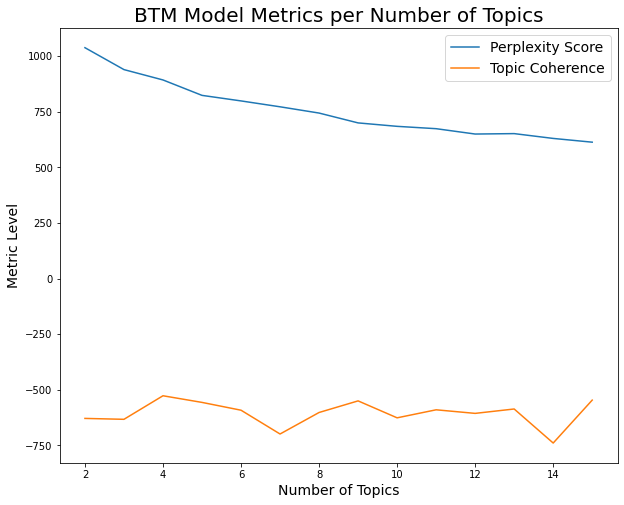

In [72]:
plt.figure(figsize=(10,8))
ax = sns.lineplot(x=num_topics[:], y=perplexity_list, label='Perplexity Score')
ax = sns.lineplot(x=num_topics[:], y=coherence_list[-1][:-1], label='Topic Coherence')


ax.axes.set_title('BTM Model Metrics per Number of Topics', fontsize=20)
ax.set_ylabel('Metric Level', fontsize=14)
ax.set_xlabel('Number of Topics', fontsize=14)
plt.legend(fontsize=14)
plt.show()

Therefore, 4 or 9 number of topics seems to have the best solution

In [ ]:
!pip install tmplot

In [78]:
import tmplot as tmp

In [75]:
# INITIALIZING AND RUNNING MODEL
# Set number of topics to the optimal of 9
model = btm.BTM(
    X, vocabulary, seed=12321, T=9, M=20, alpha=50/8, beta=0.01)
model.fit(biterms, iterations=20)
p_zd = model.transform(docs_vec)

# METRICS
perplexity = btm.perplexity(model.matrix_topics_words_, p_zd, X, 8)
coherence = btm.coherence(model.matrix_topics_words_, X, M=20)

100%|██████████| 26839/26839 [00:00<00:00, 124892.99it/s]


In [184]:
# btm optimal number of topic perplexity
perplexity

854.18513412109

In [189]:
# btm optimal number of topic coherence score
coherence[-1]

-577.6865449764041

The tmp.report generates an interactive report screen to investigate relevant words, top documents in a topic for each topic.

In [80]:
# Get the most relevant words for each topic
tmp.report(model=model, docs=test_df['text'].str.strip().tolist())

In [105]:
# generated top 30 documents for each topic,  
top_docs_topic1 = tmp.get_top_docs(docs = test_df['text'].str.strip().tolist(), model=model, docs_num=30, topics=[1])
top_docs_topic1

topic1
0   <U+266A> Hellooooo, hellooooo, helloooooo, how...
1   Essendon\r\nJordan Clark\r\nJiminie\r\nSouth A...
2   omgggg t1111111 <U+0001F62D><U+0001F62D><U+000...
3   "Where's Axe?"\r\n\r\n#TI10 https://t.co/DsIvf...
4                 Orbiting Grandmas do it again #TI10
5     #ti10 thx kyle #DreamOG https://t.co/E6dwaOC932
6   Putin-approved #TI10 #Dota2 #dota2TI https://t...
7                                 silencer easy #TI10
8                                 silencer easy #TI10
9                                     xin cutie #TI10
10             AMS.Lina #TI10 https://t.co/dpOZWOeZlx
11  PUPPEEEEEEY PUUUUNCH! #TI10 https://t.co/MwQmb...
12           WHAT DID JUST HAPPENOMGG LGDDDDDDD #TI10
13  Who the f*ck is Tony. #TI10  #OGdota  #OG #Dre...
14               ench is deceptively tanky woah #TI10
15           Nonton MPL #TI10 https://t.co/lcAH2Y41Gv
16  Caught in the river!!\r\n\r\n#TI10 #ICICESTPAR...
17  pattern design\r\n#auspol #KimKardashian #Squi...
18        Desperately waiting for #TrueSight of #TI10
19  WHAT. \r\n\r\nTHE EVERLOVING. \r\n\r\nINSANITY...
20  Why are they masked up all of a sudden <U+0001...
21  #DreamOG #Ti10 hey dotards https://t.co/CYZLQL...
22       "Hey smokers," #TI10 https://t.co/rgdDKGjI9s
23          Santino with the fakes <U+0001F602> #TI10
24                cheeky from @SumaaaaiL #Dota2 #ti10
25               Lmao, Grandma is impostor. \r\n#TI10
26   GAMBLING PROBLEMS. #TI10 https://t.co/iMIwh2XbXi
27                              ARTURITO GAMING #TI10
28                           Suma1l the god #TI10 #OG
29                            SKEWER? CeBayed.  #TI10

In [106]:
# store each topic to investigate for the full text, repetitively change the code about to get document of each variable
top_docs_topic1.to_csv("topic1_top_docs.csv")

#### In bitermplus, matrix_topics_docs returns the documents vs topics probabilities matrix, therefore assigning the topic probability back to the matrix.

In [133]:
# topic probability for each document
# note that test_df2 is a copy of test_df just after preprocessing
test_df2["0"] = model.matrix_topics_docs_[0]
test_df2['1'] = model.matrix_topics_docs_[1]
test_df2['2'] = model.matrix_topics_docs_[2]
test_df2['3'] = model.matrix_topics_docs_[3]
test_df2['4'] = model.matrix_topics_docs_[4]
test_df2['5'] = model.matrix_topics_docs_[5]
test_df2['6'] = model.matrix_topics_docs_[6]
test_df2['7'] = model.matrix_topics_docs_[7]
test_df2['8'] = model.matrix_topics_docs_[8]

In [137]:
test_df2.iloc[:,np.r_[-9:0]].max(axis =1)

41838    0.814931
41837    0.814931
37662    0.713136
41836    0.224136
34689    0.312908
           ...   
28       0.985403
26       0.995697
21       0.281078
20       0.196339
1        0.245075
Length: 26839, dtype: float64

In [135]:
# assign the document its main topic based on the highest topic probability
test_df2['main_topic'] = test_df2.iloc[:,np.r_[-9:0]].idxmax(axis =1)

In [140]:
# probability of the main topic
test_df2['main_topic_prob'] = test_df2.iloc[:,np.r_[-10:-1]].max(axis =1)

In [145]:
# aggregate the created_at into day
test_df2['rounded_date'] = test_df2.created_at.dt.round('d')

In [182]:
# save the df for further analysis
test_df2.to_csv("btm_with_topic_lable.csv")

In [149]:
topic_by_date = (test_df2.groupby(['rounded_date', 'main_topic']).size() 
   .sort_values(ascending=True) 
   .reset_index(name='count'))

In [54]:
btm_ti10 = pd.read_csv('btm_with_topic_lable.csv', encoding = 'utf-8')

In [55]:
btm_ti10.main_topic.value_counts()

2    6271
7    3688
3    3685
4    3486
1    2380
8    2159
6    1923
5    1917
0    1330
Name: main_topic, dtype: int64

### EDA using BTM
Best model over LDA, NMF and BTM

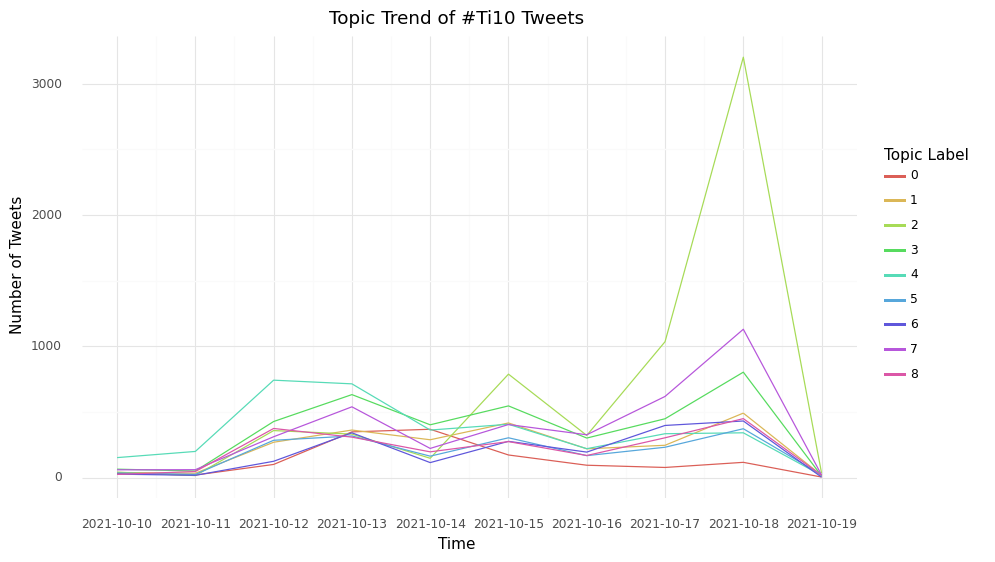

<ggplot: (8783829959673)>

In [178]:
#  p =\
(
    ggplot(aes(x = "rounded_date", y = "count", color = "main_topic"), data= topic_by_date)
    +geom_line()
    +theme_minimal()
    +theme(figure_size=(10, 6))
    #+theme(axis_text_x=element_text(angle=45))
    +labs(
        title = "Topic Trend of #Ti10 Tweets",
        x = "Time",
        y = "Number of Tweets",
        color = 'Topic Label')
   
  )
#p.save(filename = "topic_trend.png", dpi = 250) 

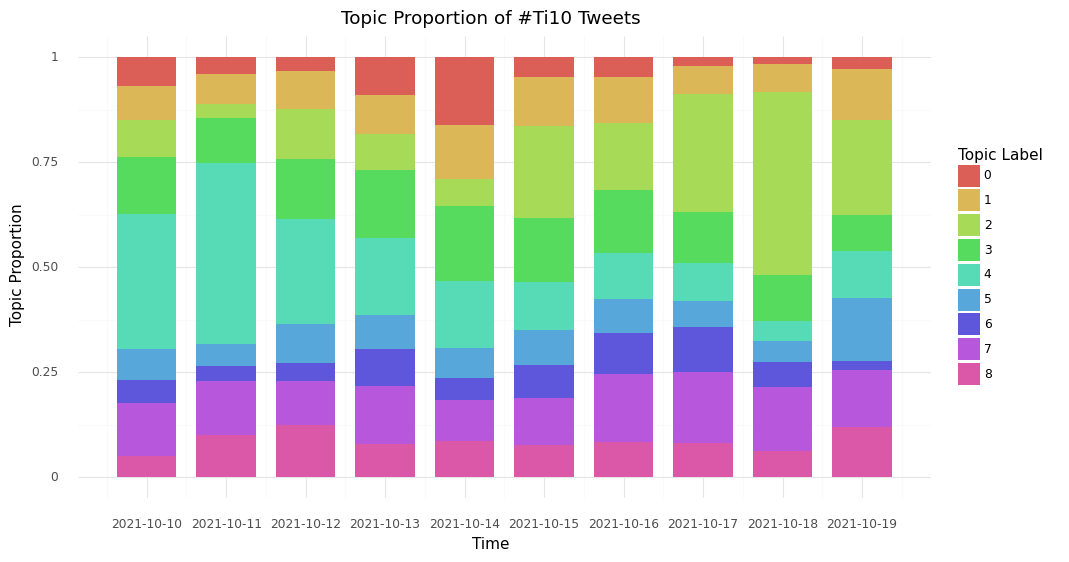

<ggplot: (8783829410093)>

In [181]:
#p=\
(
    ggplot(aes(x = "rounded_date", y = "count", fill = "main_topic"), data= topic_by_date)
    +geom_col(position = 'fill', stat = 'identity', width =0.75)
    +theme_minimal()
    +theme(figure_size=(11, 6))
    #+theme(axis_text_x=element_text(angle=45))
    +labs(
        title = "Topic Proportion of #Ti10 Tweets",
        x = "Time",
        y = "Topic Proportion",
        fill = 'Topic Label'
        )
   
  )
#p.save(filename = "topic_prop.png", dpi = 250)